In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce
from scipy.stats import multinomial
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

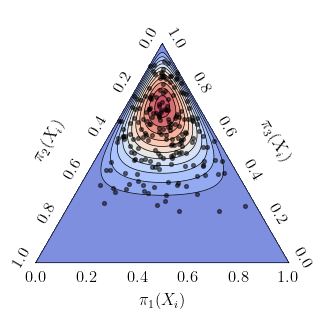

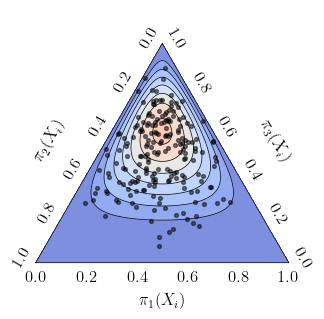

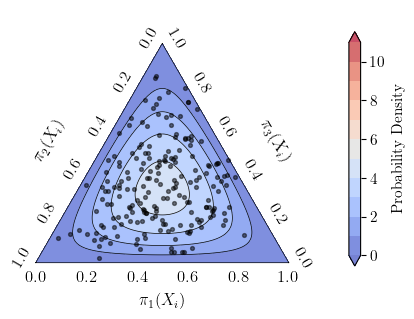

In [2]:
_corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def plot_points(i,X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.'''
    if barycentric is True:
        X = X.dot(_corners)
    plt.scatter(X[:, 0], X[:, 1], s=7.5, **kwargs)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1) for (xx, aa) in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(i,dist, nlevels=10, subdiv=8, cmap='coolwarm', **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).'''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    # Plot the contours
    contour = plt.tricontourf(trimesh, pvals, levels=np.linspace(0, 11, 12), cmap=cmap, extend='both', **kwargs)
    plt.tricontour(trimesh, pvals, levels=np.linspace(0, 11, 12), colors='k', linewidths=0.5, extend="both", **kwargs)

    # Plot the triangle boundary in black
    plt.triplot(_triangle, linewidth=0.5, color='black')

    # Add ticks and labels
    tick_positions = np.linspace(0, 1, num=6)
    for pos in tick_positions:
        # Bottom edge (X3 axis)
        plt.plot([pos, pos], [0, 0], 'k-', lw=1)
        plt.text(pos, -0.06, f'{pos:.1f}', ha='center', va='center', fontsize=12)
        
        # Left edge (X1 axis)
        x = 0.5 * pos
        y = np.sqrt(3) / 2 * pos
        plt.plot([x, x], [y, y], 'k-', lw=1)
        plt.text(x - 0.01, y + 0.02, f'{1 - pos:.1f}', ha='right', va='center', fontsize=12, rotation=60)

        # Right edge (X2 axis)
        x = 1 - 0.5 * pos
        y = np.sqrt(3) / 2 * pos
        plt.plot([x, x], [y, y], 'k-', lw=1)
        plt.text(x + 0.01, y + 0.02, f'{pos:.1f}', ha='left', va='center', fontsize=12, rotation=-60)
    
    plt.text(0.5, -0.15, '$\pi_1(X_i)$', ha='center', va='center', fontsize=12)
    plt.text(0.05, np.sqrt(3) / 4 + 0.05, '$\pi_2(X_i)$', ha='center', va='center', fontsize=12, rotation=60)
    plt.text(0.95, np.sqrt(3) / 4 + 0.05, '$\pi_3(X_i)$', ha='center', va='center', fontsize=12, rotation=-60)

    plt.axis('equal')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.0)
    plt.axis('off')
    
    # Add a colorbar
    if i ==2:
        cbar = plt.colorbar(contour, ax=plt.gca(), orientation='vertical', fraction=0.035, pad=0.15)
        cbar.ax.tick_params(labelsize=11)
        cbar.ax.yaxis.label.set_size(11)
        cbar.set_label('Probability Density')

def lighten_color_map(cmap, scale=0.5):
    '''Returns a lighter version of the given colormap.'''
    cdict = cmap._segmentdata.copy()
    for key in ('red', 'green', 'blue'):
        cdict[key] = [(x[0], 1 - scale * (1 - x[1]), 1 - scale * (1 - x[2])) for x in cdict[key]]
    return LinearSegmentedColormap(f'{cmap.name}_light', cdict)

if __name__ == '__main__':
    
    alphas = [[2, 2, 6], [2,2,4], [2, 2, 2]]
    #n_trials = 50 # Number of trials in multinomial distribution
    np.random.seed(None)
    cmap = lighten_color_map(plt.cm.coolwarm, scale=0.7)

    for (i, alpha) in enumerate(alphas):
        if i==2:
            f = plt.figure(figsize=(3.89, 3))
        else:
            f = plt.figure(figsize=(3, 3))
        dist = Dirichlet(alpha)
        draw_pdf_contours(i,dist, cmap=cmap)

        # Generate and plot Dirichlet samples
        dirichlet_samples = dist.sample(200)
        plot_points(i,dirichlet_samples, barycentric=True, border=True, color='black', alpha=0.5)

        plt.tight_layout(pad=0.1)  # Reduce padding
        plt.show()